In [1]:
import torch
import numpy as np
import pandas as pd
import yaml

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator

from torch_geometric.loader import DataLoader
from torch_scatter import scatter_mean

from symgraph.data_utils import create_graphs, edge_index_zeo, get_transform_matrix, set_generators
from symgraph.dataset import create_dataloaders
from symgraph.model.model_utils import log_langmuir_freundlich_2s
from symgraph.model.model import GNN

import spglib

from copy import deepcopy
from tqdm import tqdm

c:\Users\20175552\.conda\envs\flowmm\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
title_size = 10
label_size = 8
tick_size = 6

In [3]:
tr, _, _ = create_graphs(edge_type='radius', radius=8)
# tr = torch.load('bestmodel/all_graphs.pt')

ABW has too many inaccurate HOA values. Skipping.
ACO has too many inaccurate HOA values. Skipping.
AEI has 20 inaccurate HOA values. This is 13.51% of the data.
HOA range: 20.142, Max error: 1.007, Max HoA: 45.266, Min HoA: 25.124
AEL has too many inaccurate HOA values. Skipping.
AEN has too many inaccurate HOA values. Skipping.
AET has 26 inaccurate HOA values. This is 20.80% of the data.
HOA range: 28.520, Max error: 1.426, Max HoA: 50.919, Min HoA: 22.399
AFG has 37 inaccurate HOA values. This is 25.00% of the data.
HOA range: 31.237, Max error: 1.500, Max HoA: 59.692, Min HoA: 28.455
AFI has too many inaccurate HOA values. Skipping.
AFN has too many inaccurate HOA values. Skipping.
AFO has too many inaccurate HOA values. Skipping.
AFR has 21 inaccurate HOA values. This is 13.04% of the data.
HOA range: 20.976, Max error: 1.049, Max HoA: 45.279, Min HoA: 24.303
AFS has 11 inaccurate HOA values. This is 8.03% of the data.
HOA range: 28.330, Max error: 1.417, Max HoA: 50.495, Min HoA

In [4]:
len(tr)

27648

In [6]:
_, _, te_int = create_graphs(edge_type='radius', radius=8, val_split=0.1, test_split=0.1)
# te_int = torch.load('bestmodel/int_graphs.pt')

ABW has too many inaccurate HOA values. Skipping.
ACO has too many inaccurate HOA values. Skipping.
AEI has 20 inaccurate HOA values. This is 13.51% of the data.
HOA range: 20.142, Max error: 1.007, Max HoA: 45.266, Min HoA: 25.124
AEL has too many inaccurate HOA values. Skipping.
AEN has too many inaccurate HOA values. Skipping.
AET has 26 inaccurate HOA values. This is 20.80% of the data.
HOA range: 28.520, Max error: 1.426, Max HoA: 50.919, Min HoA: 22.399
AFG has 37 inaccurate HOA values. This is 25.00% of the data.
HOA range: 31.237, Max error: 1.500, Max HoA: 59.692, Min HoA: 28.455
AFI has too many inaccurate HOA values. Skipping.
AFN has too many inaccurate HOA values. Skipping.
AFO has too many inaccurate HOA values. Skipping.
AFR has 21 inaccurate HOA values. This is 13.04% of the data.
HOA range: 20.976, Max error: 1.049, Max HoA: 45.279, Min HoA: 24.303
AFS has 11 inaccurate HOA values. This is 8.03% of the data.
HOA range: 28.330, Max error: 1.417, Max HoA: 50.495, Min HoA

In [7]:
te, _, _ = create_graphs(zeo_codes=['ITW','CHA'],edge_type='radius', radius=8)
# te = torch.load('bestmodel/gen_graphs.pt')

ITW has 498 inaccurate HOA values. This is 50.30% of the data.
HOA range: 73.646, Max error: 1.500, Max HoA: 101.381, Min HoA: 27.735
CHA has 84 inaccurate HOA values. This is 10.24% of the data.
HOA range: 18.318, Max error: 0.916, Max HoA: 43.834, Min HoA: 25.516
Dropped 582 out of 1810 samples. This is 32.15% of the data.


In [8]:
len(tr), len(te), len(te_int)

(27648, 1228, 2717)

In [9]:
hoa = [g.y for g in tr]
ats = [np.array(g.x) for g in tr]

iso = np.array([g.iso for g in tr])
iso_params = [g.iso_params for g in tr]
names = [g.zeo for g in tr]

In [10]:
unames, cnts = np.unique(names, return_counts=True)

# sort names by count
unames = unames[np.argsort(cnts)[::-1]]
cnts = cnts[np.argsort(cnts)[::-1]]

cnts, unames

(array([4300, 1704, 1571, 1177, 1150,  772,  736,  661,  614,  530,  527,
         503,  492,  482,  469,  464,  427,  425,  275,  159,  155,  149,
         146,  145,  140,  140,  139,  139,  137,  137,  137,  135,  135,
         134,  131,  130,  129,  128,  128,  126,  125,  125,  123,  123,
         123,  122,  122,  122,  121,  121,  121,  121,  120,  120,  120,
         120,  120,  119,  119,  118,  118,  117,  117,  117,  116,  116,
         116,  115,  115,  114,  113,  113,  113,  113,  113,  112,  112,
         111,  111,  110,  109,  109,  109,  107,  107,  106,  106,  105,
         105,  104,  104,  103,  102,  101,  101,  100,   99,   99,   97,
          95,   92,   91,   89,   88,   88,   85,   84,   78], dtype=int64),
 array(['MOR', 'MFI', 'FAU', 'DDR', 'RHO', 'LTA', 'CHA', 'BEC', 'MEL',
        'NAT', 'ERI', 'YFI', 'ITW', 'FER', 'MER', 'LTL', 'MTW', 'HEU',
        'TON', 'CSV', 'BPH', 'SFO', 'SFE', 'MEI', 'AFR', 'JSR', 'PTY',
        'PWO', 'SGT', 'RWY', 'SAS', 'IRN', '

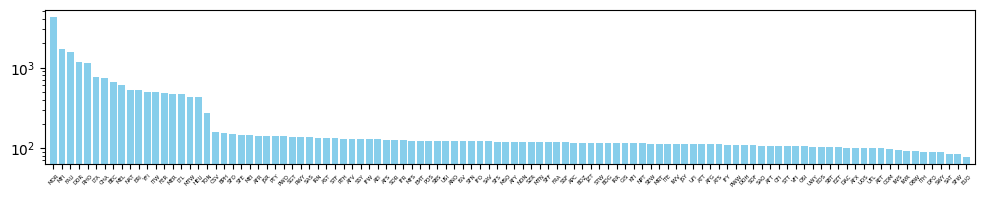

In [11]:
# bar chart of zeolite counts

plt.figure(figsize=(12,2))

plt.bar(unames, cnts, color='skyblue')
plt.yscale('log')
plt.xlim(-1, len(unames))
plt.xticks(rotation=45, fontsize=4);

In [12]:
al_prop = np.array([np.mean(a) for a in ats])


In [13]:
hoa = np.array(hoa)[al_prop <= 0.25]
al_prop = al_prop[al_prop <= 0.25]


# Hoa dist

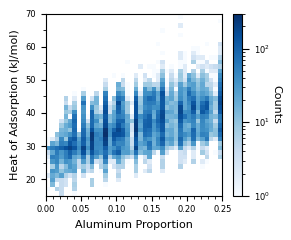

In [15]:


plt.figure(figsize=(3, 2.5))

# Create the 2D histogram with log scaling
plt.hist2d(al_prop, hoa, bins=(40, 40), norm=LogNorm(), cmap="Blues")

# Add colorbar
cbar = plt.colorbar()
cbar.set_label("Counts", fontsize=label_size, rotation=270, labelpad=8)

# set label size of colorbar
cbar.ax.tick_params(labelsize=tick_size, size=5)

# Labels and title
plt.xlabel("Aluminum Proportion", fontsize=label_size)
plt.ylabel("Heat of Adsorption (kJ/mol)", fontsize=label_size)

plt.xticks(np.arange(0, .3, 0.05), fontsize=tick_size)
plt.xticks(np.arange(0, 0.26, 0.01), minor=True)

plt.yticks(np.arange(20, 80, 10), fontsize=tick_size)
plt.yticks(np.arange(20, 70, 5), minor=True)

plt.xlim(-0.00, 0.25);
plt.tight_layout()
plt.savefig('figures/hoa_dist.pdf', bbox_inches='tight')

# Isotherm dist

In [16]:
iso_ats = [a for a, i in zip(ats, iso) if i == 1]
iso_pars = np.concatenate([p for p, i in zip(iso_params, iso) if i == 1])
iso_name = [n for n, i in zip(names, iso) if i == 1]

In [17]:
p = np.array([1, 1.47712, 2, 2.47712, 3, 3.47712, 4, 4.47712, 5, 5.47712, 6, 6.47712, 7])

In [18]:
qs = log_langmuir_freundlich_2s(iso_pars, p[:,None]).T

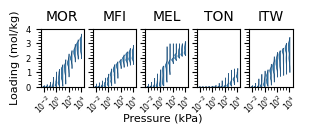

In [19]:
fig, ax = plt.subplots(1, 5, figsize=(3.25, .75))

for i, name in enumerate(['MOR', 'MFI', 'MEL', 'TON', 'ITW']):

    mask = np.array([n == name for n in iso_name])

    q = qs[mask]

    viol = ax[i].violinplot(q, positions=p, showextrema=False, bw_method='scott', side='low')

    for pc in viol['bodies']:
        pc.set_edgecolor('#154B79')
        pc.set_linewidth(0.5)
        pc.set_alpha(0.9)

    ax[i].set_xlim(0.5, 7.5)
    ax[i].set_ylim(0, 4)

    # plot logarithmic major and minor x ticks
    ps = np.array([1, 3, 5, 7])
    ax[i].set_xticks(ps, [r'10$^{-2}$', r'10$^0$', r'10$^2$', r'10$^4$'], rotation=45)
    ax[i].xaxis.set_tick_params(labelsize=tick_size-.5, pad=1)
    ax[i].set_xticks([1, 1.47712, 2, 2.47712, 3, 3.47712, 4, 4.47712, 5, 5.47712, 6, 6.47712, 7], minor=True)

    # ax[i].set_xlabel('Pressure (kPa)', fontsize=label_size)

    ax[i].set_title(name, fontsize=title_size)

    if i == 0:
        ax[i].set_yticks(np.arange(0, 5, 1))
        ax[i].yaxis.set_tick_params(labelsize=tick_size)
    else:
        ax[i].set_yticks(np.arange(0, 5,1), [])

    ax[i].set_yticks(np.arange(0, 4.2, 0.2), minor=True)

ax[0].set_ylabel('Loading (mol/kg)', fontsize=label_size)


fig.text(0.5, -0.35, 'Pressure (kPa)', ha='center', fontsize=label_size)
# plt.tight_layout()
plt.savefig('figures/iso_violin.pdf', bbox_inches='tight')

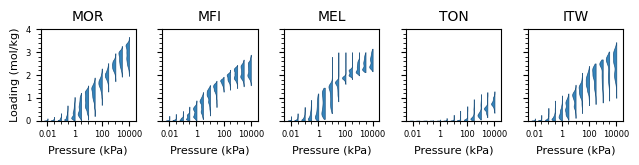

In [20]:
fig, ax = plt.subplots(1, 5, figsize=(6.5, 1.75))

for i, name in enumerate(['MOR', 'MFI', 'MEL', 'TON', 'ITW']):

    mask = np.array([n == name for n in iso_name])

    q = qs[mask]

    viol = ax[i].violinplot(q, positions=p, showextrema=False, bw_method='scott', side='low')

    for pc in viol['bodies']:
        pc.set_edgecolor('#154B79')
        pc.set_linewidth(0.5)
        pc.set_alpha(0.9)

    ax[i].set_xlim(0.5, 7.5)
    ax[i].set_ylim(0, 4)

    # plot logarithmic major and minor x ticks
    ps = np.array([1, 3, 5, 7])
    ax[i].set_xticks(ps, [0.01, 1, 100, 10000])
    ax[i].xaxis.set_tick_params(labelsize=tick_size)
    ax[i].set_xticks([1.47712, 2, 2.47712, 3, 3.47712, 4, 4.47712, 5, 5.47712, 6, 6.47712], minor=True)

    ax[i].set_xlabel('Pressure (kPa)', fontsize=label_size)

    ax[i].set_title(name, fontsize=title_size)

    if i == 0:
        ax[i].set_yticks(np.arange(0, 5, 1))
        ax[i].yaxis.set_tick_params(labelsize=tick_size)
    else:
        ax[i].set_yticks(np.arange(0, 5,1), [])

    ax[i].set_yticks(np.arange(0, 4.2, 0.2), minor=True)

ax[0].set_ylabel('Loading (mol/kg)', fontsize=label_size)


plt.tight_layout()
plt.savefig('figures/iso_violin.pdf', bbox_inches='tight')


In [21]:
q_idx = [0, 4, 8, 12]
p.shape

(13,)

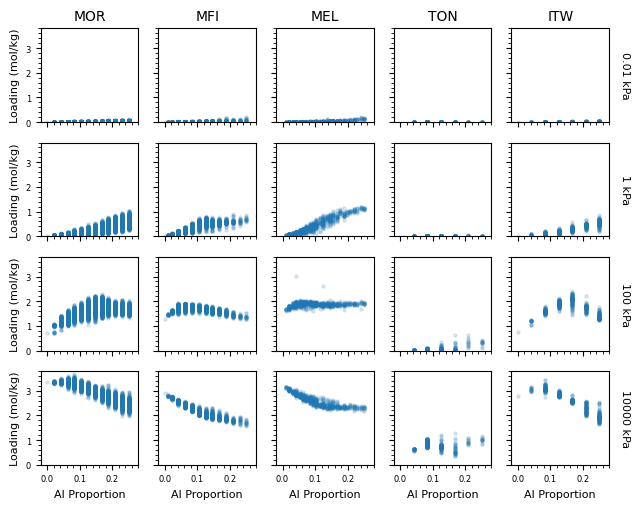

In [22]:
fig, ax = plt.subplots(len(q_idx), 5, figsize=(6.5, 5.2))

for i, name in enumerate(['MOR', 'MFI', 'MEL', 'TON', 'ITW']):

    mask = np.array([n == name for n in iso_name])


    for j in range(len(q_idx)):
        q = qs[mask, q_idx[j]]

        a = np.array([a for a, m in zip(iso_ats, mask) if m])
        a = np.squeeze(a).mean(axis=1)

        ax[j,i].scatter(a, q, alpha=0.15, s=5)
        
        ax[j,i].set_xlim(-0.02, 0.27)
        ax[j,i].set_ylim(0, 3.8)

        
        if j == len(q_idx) - 1:
            ax[j,i].set_xticks([0, 0.1, 0.2])
            ax[j,i].xaxis.set_tick_params(labelsize=tick_size)
        else:
            ax[j,i].set_xticks([0, 0.1, 0.2], [])
        
        if i == 0:
            ax[j,i].set_yticks([0, 1, 2, 3])
            ax[j,i].yaxis.set_tick_params(labelsize=tick_size)
        else:
            ax[j,i].set_yticks([0, 1, 2, 3], [])
        
        
        ax[j,i].set_xticks(np.arange(-0.00, 0.3, 0.02), minor=True)
        
        ax[j,i].set_yticks(np.arange(0.00, 4, 0.2), minor=True)
    
    
    
    ax[0,i].set_title(name, fontsize=title_size)
    ax[-1,i].set_xlabel('Al Proportion', fontsize=label_size)

for j in range(len(q_idx)):
    ax[j,0].set_ylabel('Loading (mol/kg)', fontsize=label_size)


# set y labels on the right side of the figure

p_labels = [0.01, 1, 100, 10000]

for j in range(len(q_idx)):

    # ax[j,-1].set_ylabel(f'{(10**p[q_idx[j]])/1000} kPa')
    ax[j,-1].set_ylabel(f'{p_labels[j]} kPa', rotation=270, labelpad=15, fontsize=label_size)
    ax[j,-1].yaxis.set_label_position("right")

plt.tight_layout()

plt.savefig('figures/iso_scatter.pdf', bbox_inches='tight')

# Evaluation metrics

In [23]:
model_names = ['sym_gen', 'nosym_gen', 'sym_int', 'nosym_int']	

In [24]:
testloader = DataLoader(te, batch_size=64, shuffle=False)
testloader_int = DataLoader(te_int, batch_size=64, shuffle=False)

In [25]:
true_isos = []
pred_isos = []

true_hoas = []
pred_hoas = []

true_isos_small = []
pred_isos_small = []
isos_ats = []
isos_top = []

itw_mask = []

for m in model_names:

    if 'gen' in m:
        loader = testloader
    else:
        loader = testloader_int


    pth = f'bestmodel/{m}'
    with open(f'{pth}/config.yaml') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

    model = GNN(**config['model']).cuda()
    model.load_state_dict(torch.load(f'{pth}/final.pth'))


    mu = np.load(f'{pth}/mu.npy')
    std = np.load(f'{pth}/std.npy')
    # print(model)

    true = []
    pred = []
    err = []

    true_iso = []
    pred_iso = []

    true_iso_small = []
    pred_iso_small = []

    is_ats = []
    is_top = []

    total_iso = 0

    p = torch.linspace(1, 7, 100).to('cuda').unsqueeze(-1)
    dp = p[1] - p[0]
    p_in = torch.cat([p, p[[-1]] + dp], dim=0) - dp/2

    p2 = torch.tensor([1, 1.47712, 2, 2.47712, 3, 3.47712, 4, 4.47712, 5, 5.47712, 6, 6.47712, 7]).to('cuda').unsqueeze(-1)
    dp2 = p2[1] - p2[0]
    p_in2 = torch.cat([p2, p2[[-1]] + dp2], dim=0) - dp2/2


    
    for data in loader:
    
        data = data.to('cuda')
        
        # pres = pres.repeat(data.y.size(0), 1)
        
        
        
        with torch.no_grad():
            out, q_prime_hat = model(data, pres=p_in)
            _, q_prime_hat_small = model(data, pres=p_in2)
        true_isotherm = log_langmuir_freundlich_2s(data.iso_params, p).T
        pred_isotherm = torch.cumulative_trapezoid(q_prime_hat, p_in.squeeze(-1), dim=-1)

        true_isotherm_small = log_langmuir_freundlich_2s(data.iso_params, p2).T
        pred_isotherm_small = torch.cumulative_trapezoid(q_prime_hat_small, p_in2.squeeze(-1), dim=-1)

        b_ats = scatter_mean(data.x, data.batch, dim=0)
        

        iso_mask = data.iso == 1

        if m == 'sym_gen':
            itw_mask.extend(iso_mask.cpu().numpy().tolist())

        n_iso = iso_mask.sum().item()

        
        total_iso += n_iso

        true_isotherm = true_isotherm[iso_mask]
        pred_isotherm = pred_isotherm[iso_mask]

        true_isotherm_small = true_isotherm_small[iso_mask]
        pred_isotherm_small = pred_isotherm_small[iso_mask]

        b_ats = b_ats[iso_mask]
        b_top = [data.zeo[i] for i in range(len(data.zeo)) if iso_mask[i]]
        
        if n_iso > 0:
            true_iso.extend(true_isotherm.cpu().numpy().tolist())
            pred_iso.extend(pred_isotherm.cpu().numpy().tolist())
            true_iso_small.extend(true_isotherm_small.cpu().numpy().tolist())
            pred_iso_small.extend(pred_isotherm_small.cpu().numpy().tolist())
            is_ats.extend(b_ats.cpu().numpy().tolist())
            is_top.extend(b_top)


        out = out.squeeze(-1)

        true.extend(data.y.cpu().numpy().tolist())
        pred.extend(out.cpu().numpy().tolist())

    
    true = np.array(true)
    pred = np.array(pred)

    pred = pred * std + mu

    true_iso = np.array(true_iso)
    pred_iso = np.array(pred_iso)

    true_iso_small = np.array(true_iso_small)
    pred_iso_small = np.array(pred_iso_small)

    is_ats = np.array(is_ats)
    is_top = np.array(is_top)
    
    true_isos.append(true_iso)
    pred_isos.append(pred_iso)

    true_hoas.append(true)
    pred_hoas.append(pred)

    true_isos_small.append(true_iso_small)
    pred_isos_small.append(pred_iso_small)

    isos_ats.append(is_ats)
    isos_top.append(is_top)



In [26]:
itw_mask = np.array(itw_mask)

ph = pred_hoas[0]
th = true_hoas[0]

ae = np.abs(ph - th)
se = ae**2

print(ae.shape, itw_mask.shape)

mae_itw = np.mean(ae[itw_mask])
mse_itw = np.mean(se[itw_mask])

mae_cha = np.mean(ae[~itw_mask])
mse_cha = np.mean(se[~itw_mask])

mae_itw, mse_itw, mae_cha, mse_cha


(1228,) (1228,)


(1.9621974713894383, 6.445081947685302, 1.3807786559251498, 3.3291528886914126)

In [27]:
df = pd.DataFrame(columns=['MAE hoa', 'MSE hoa', 'MAE iso', 'MSE iso', 'MAE iso sat', 'MSE iso sat'], index=model_names)

for i in range(len(model_names)):

    ph = pred_hoas[i]
    th = true_hoas[i]

    pi = pred_isos[i]
    ti = true_isos[i]

    err_h = np.abs(ph - th)
    mae_h = np.mean(err_h)
    mse_h = np.mean(err_h**2)

    err_i = np.abs(pi - ti)
    mae_i = np.mean(err_i)
    mse_i = np.mean(err_i**2)

    err_i_s = err_i[:, -10:]
    mae_i_s = np.mean(err_i_s)
    mse_i_s = np.mean(err_i_s**2)

    df.loc[model_names[i]] = [mae_h, mse_h, mae_i, mse_i, mae_i_s, mse_i_s]

df


,MAE hoa,MSE hoa,MAE iso,MSE iso,MAE iso sat,MSE iso sat
sym_gen,1.613725,4.577554,0.354304,0.196539,0.17092,0.045403
nosym_gen,1.771014,5.146189,0.314097,0.173741,0.660988,0.517444
sym_int,1.387225,3.630505,0.074356,0.010837,0.102,0.016788
nosym_int,1.423319,3.748594,0.068532,0.009378,0.101011,0.016082


## Interpolation

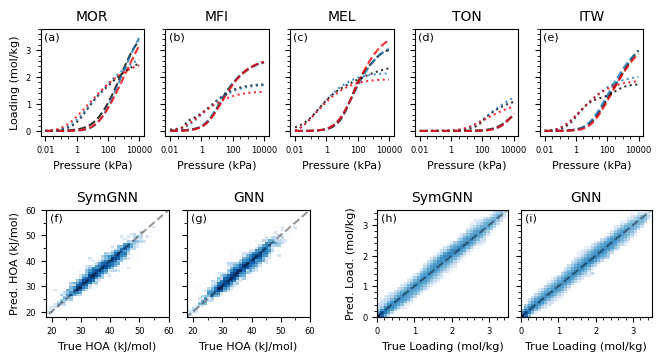

In [28]:
fig = plt.figure(layout='constrained', figsize=(6.5, 3.5))
subfigs = fig.subfigures(2, 1, hspace=0.07)

axt = subfigs[0].subplots(1, 5, sharey=True, sharex=True)

subfigs2 = subfigs[1].subfigures(1, 2, wspace=0.07)

axbl = subfigs2[0].subplots(1, 2, sharex=True, sharey=True)
axbr = subfigs2[1].subplots(1, 2, sharex=True, sharey=True)

p_plot = p.squeeze().cpu().numpy()

for i, name in enumerate(['MOR', 'MFI', 'MEL', 'TON', 'ITW']):

    # select zeolites with low al proportion
    mask = (isos_top[2] == name) & (isos_ats[2].squeeze() <= 0.05)
    
    true = true_isos[2][mask][0]
    pred_sym = pred_isos[2][mask][0]
    pred_nosym = pred_isos[3][mask][0]

    axt[i].plot(p_plot, true, label='True', color='black', linestyle='--', alpha=0.8)
    axt[i].plot(p_plot, pred_sym, label='SymGNN', color='#1F77B4', linestyle='--', alpha=0.8)
    axt[i].plot(p_plot, pred_nosym, label='GNN', color='red', linestyle='--', alpha=0.8)

    # select zeolites with high al proportion
    mask = (isos_top[2] == name) & (isos_ats[2].squeeze() > 0.23)

    true = true_isos[2][mask][0]
    pred_sym = pred_isos[2][mask][0]
    pred_nosym = pred_isos[3][mask][0]

    axt[i].plot(p_plot, true, color='black', linestyle=':', alpha=0.8)
    axt[i].plot(p_plot, pred_sym, color='#1F77B4', linestyle=':', alpha=0.8)
    axt[i].plot(p_plot, pred_nosym, color='red', linestyle=':', alpha=0.8)

    ps = np.array([1, 3, 5, 7])
    axt[i].set_xticks(ps, [0.01, 1, 100, 10000])
    axt[i].xaxis.set_tick_params(labelsize=tick_size)

    axt[i].set_xticks([1.47712, 2, 2.47712, 3, 3.47712, 4, 4.47712, 5, 5.47712, 6, 6.47712], minor=True)

    axt[i].set_title(name, fontsize=title_size)
    axt[i].set_xlabel('Pressure (kPa)', fontsize=label_size)

    axt[i].xaxis.set_tick_params(labelsize=tick_size)
    axt[i].yaxis.set_tick_params(labelsize=tick_size)

    axt[i].set_yticks(np.arange(0, 4, 0.2), minor=True)

    if i == 0:
        axt[i].set_ylabel('Loading (mol/kg)', fontsize=label_size)



axbl[0].hist2d(true_hoas[2], pred_hoas[2], bins=(40, 40), norm=LogNorm(), cmap='Blues')
axbl[0].plot([0, 100], [0, 100], 'k--', alpha=0.4)

axbl[0].set_xlim(18, 60)
axbl[0].set_ylim(18, 60)

axbl[0].set_ylabel('Pred. HOA (kJ/mol)', fontsize=label_size)
axbl[0].set_xlabel('True HOA (kJ/mol)', fontsize=label_size)

axbl[0].set_xticks(np.arange(20, 70, 10))
axbl[0].set_xticks(np.arange(20, 65, 5), minor=True)
axbl[0].set_yticks(np.arange(20, 70, 10))
axbl[0].set_yticks(np.arange(20, 65, 5), minor=True)

axbl[0].xaxis.set_tick_params(labelsize=tick_size)
axbl[0].yaxis.set_tick_params(labelsize=tick_size)


axbl[0].set_title('SymGNN', fontsize=title_size)

axbl[1].hist2d(true_hoas[3], pred_hoas[3], bins=(40, 40), norm=LogNorm(), cmap='Blues')
axbl[1].plot([0, 100], [0, 100], 'k--', alpha=0.4)

axbl[1].set_xlim(18, 60)
axbl[1].set_ylim(18, 60)

axbl[1].xaxis.set_tick_params(labelsize=tick_size)
axbl[1].yaxis.set_tick_params(labelsize=tick_size)

axbl[1].set_xlabel('True HOA (kJ/mol)', fontsize=label_size)

axbl[1].set_title('GNN', fontsize=title_size)

axbr[0].hist2d(true_isos[2].flatten(), pred_isos[2].flatten(), bins=(40, 40), norm=LogNorm(), cmap='Blues')
axbr[0].plot([0, 4], [0, 4], 'k--', alpha=0.4)

axbr[0].set_xlim(0, 3.5)
axbr[0].set_ylim(0, 3.5)

axbr[0].set_ylabel('Pred. Load. (mol/kg)', fontsize=label_size)
axbr[0].set_xlabel('True Loading (mol/kg)', fontsize=label_size)

axbr[0].set_yticks(np.arange(0, 4, 1))
axbr[0].set_yticks(np.arange(0, 4, 0.2), minor=True)

axbr[0].set_xticks(np.arange(0, 4, 1))
axbr[0].set_xticks(np.arange(0, 4, 0.2), minor=True)

axbr[0].xaxis.set_tick_params(labelsize=tick_size)
axbr[0].yaxis.set_tick_params(labelsize=tick_size)

axbr[0].set_title('SymGNN', fontsize=title_size)

axbr[1].hist2d(true_isos[3].flatten(), pred_isos[3].flatten(), bins=(40, 40), norm=LogNorm(), cmap='Blues')
axbr[1].plot([0, 4], [0, 4], 'k--', alpha=0.4)

axbr[1].set_xlim(0, 3.5)
axbr[1].set_ylim(0, 3.5)

axbr[1].set_xlabel('True Loading (mol/kg)', fontsize=label_size)

axbr[1].xaxis.set_tick_params(labelsize=tick_size)
axbr[1].yaxis.set_tick_params(labelsize=tick_size)

axbr[1].set_title('GNN', fontsize=title_size)

labels_top = ['(a)', '(b)', '(c)', '(d)', '(e)']
for ax, label in zip(axt, labels_top):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='left')

# Add labels to bottom row (scatter plots)
labels_bottom = ['(f)', '(g)', '(h)', '(i)']
for ax, label in zip(axbl.flatten(), labels_bottom[:2]):  # Left-side scatter plots
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='left')

for ax, label in zip(axbr.flatten(), labels_bottom[2:]):  # Right-side scatter plots
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=8, 
            verticalalignment='top', horizontalalignment='left')



plt.savefig('figures/interpolation_results.pdf', bbox_inches='tight')


## Generalization

0.1666666716337204 5
0.3333333432674408 2


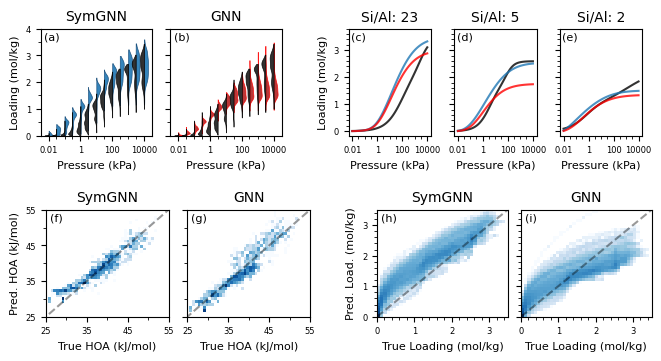

In [29]:
fig = plt.figure(layout='constrained', figsize=(6.5, 3.5))
subfigs = fig.subfigures(2, 1, hspace=0.07, height_ratios=[1, 1])

subfig21 = subfigs[0].subfigures(1, 2, wspace=0.07, width_ratios=[1, 1.2])

axtl = subfig21[0].subplots(1, 2, sharey=True, sharex=True)
axtr = subfig21[1].subplots(1, 3, sharey=True, sharex=True)

subfigs2 = subfigs[1].subfigures(1, 2, wspace=0.07)

axbl = subfigs2[0].subplots(1, 2, sharex=True, sharey=True)
axbr = subfigs2[1].subplots(1, 2, sharex=True, sharey=True)



mask = (isos_ats[0].squeeze() <= 0.05) & (isos_ats[0].squeeze() > 0)

true = true_isos[0][mask][0]
pred_sym = pred_isos[0][mask][0]
pred_nosym = pred_isos[1][mask][0]

al_per = isos_ats[0][mask][0][0]


if al_per == 0:
    axtr[0].set_title(f'Pure Si', fontsize=title_size)
else:
    si_al_ratio =  (1 - al_per) / al_per
    si_al_ratio = int(round(si_al_ratio, 0))
    axtr[0].set_title(f'Si/Al: {si_al_ratio}', fontsize=title_size)

axtr[0].plot(p_plot, true, label='True', color='black', linestyle='-', alpha=0.8)
axtr[0].plot(p_plot, pred_sym, label='SymGNN', color='#1F77B4', linestyle='-', alpha=0.8)
axtr[0].plot(p_plot, pred_nosym, label='GNN', color='red', linestyle='-', alpha=0.8)


mask = (isos_ats[0].squeeze() > 0.15) & (isos_ats[0].squeeze() <= 0.2)

true = true_isos[0][mask][0]
pred_sym = pred_isos[0][mask][0]
pred_nosym = pred_isos[1][mask][0]

al_per = isos_ats[0][mask][0][0]

si_al_ratio =  (1 - al_per) / al_per
si_al_ratio = int(round(si_al_ratio, 0))
print(al_per, si_al_ratio)

axtr[1].plot(p_plot, true, label='True', color='black', linestyle='-', alpha=0.8)
axtr[1].plot(p_plot, pred_sym, label='SymGNN', color='#1F77B4', linestyle='-', alpha=0.8)
axtr[1].plot(p_plot, pred_nosym, label='GNN', color='red', linestyle='-', alpha=0.8)

axtr[1].set_title(f'Si/Al: {si_al_ratio}', fontsize=title_size)

# select zeolites with high al proportion
mask = (isos_ats[0].squeeze() > 0.3)

true = true_isos[0][mask][0]
pred_sym = pred_isos[0][mask][0]
pred_nosym = pred_isos[1][mask][0]

al_per = isos_ats[0][mask][0][0]

si_al_ratio =  (1 - al_per) / al_per
si_al_ratio = int(round(si_al_ratio, 0))
print(al_per, si_al_ratio)

axtr[2].plot(p_plot, true, color='black', linestyle='-', alpha=0.8)
axtr[2].plot(p_plot, pred_sym, color='#1F77B4', linestyle='-', alpha=0.8)
axtr[2].plot(p_plot, pred_nosym, color='red', linestyle='-', alpha=0.8)

axtr[2].set_title(f'Si/Al: {si_al_ratio}', fontsize=title_size)

ps = np.array([1, 3, 5, 7])
axtr[0].set_xticks(ps, [0.01, 1, 100, 10000])
axtr[0].xaxis.set_tick_params(labelsize=tick_size)
axtr[1].xaxis.set_tick_params(labelsize=tick_size)
axtr[2].xaxis.set_tick_params(labelsize=tick_size)

axtr[0].set_xticks([1.47712, 2, 2.47712, 3, 3.47712, 4, 4.47712, 5, 5.47712, 6, 6.47712], minor=True)

axtr[0].set_xlabel('Pressure (kPa)', fontsize=label_size)
axtr[1].set_xlabel('Pressure (kPa)', fontsize=label_size)
axtr[2].set_xlabel('Pressure (kPa)', fontsize=label_size)

axtr[0].xaxis.set_tick_params(labelsize=tick_size)
axtr[0].yaxis.set_tick_params(labelsize=tick_size)

axtr[0].set_yticks(np.arange(0, 4, 0.2), minor=True)

axtr[0].set_ylabel('Loading (mol/kg)', fontsize=label_size)



for i in range(2):

    true_q = true_isos_small[i]
    pred_q = pred_isos_small[i]

    p2_np = p2.squeeze().cpu().numpy()


    col = '#1F77B4' if i == 0 else '#B22222'
    col2 = '#154B79' if i == 0 else 'red'
    viol = axtl[i].violinplot(pred_q, positions=p2_np, showextrema=False, bw_method='scott', side='high')

    for pc in viol['bodies']:
        pc.set_edgecolor(col2)
        pc.set_facecolor(col)
        pc.set_linewidth(0.5)
        pc.set_alpha(0.9)



    viol = axtl[i].violinplot(true_q, positions=p2_np, showextrema=False, bw_method='scott', side='low')
    for pc in viol['bodies']:
        pc.set_edgecolor('black')
        pc.set_facecolor('#1a1a1a')
        pc.set_linewidth(0.5)
        pc.set_alpha(0.9)




    axtl[i].set_xlim(0.5, 7.5)
    axtl[i].set_ylim(0, 4)

    # plot logarithmic major and minor x ticks
    ps = np.array([1, 3, 5, 7])
    axtl[i].set_xticks(ps, [0.01, 1, 100, 10000])
    axtl[i].set_xticks([1.47712, 2, 2.47712, 3, 3.47712, 4, 4.47712, 5, 5.47712, 6, 6.47712], minor=True)
    axtl[i].xaxis.set_tick_params(labelsize=tick_size)

    axtl[i].set_yticks(np.arange(0, 5, 1))
    axtl[i].set_yticks(np.arange(0, 4.5, 0.5), minor=True)
    axtl[i].yaxis.set_tick_params(labelsize=tick_size)

    axtl[i].set_xlabel('Pressure (kPa)', fontsize=label_size)

axtl[0].set_ylabel('Loading (mol/kg)', fontsize=label_size)

axtl[0].set_title('SymGNN', fontsize=title_size)
axtl[1].set_title('GNN', fontsize=title_size)


axbl[0].hist2d(true_hoas[0], pred_hoas[0], bins=(40, 40), norm=LogNorm(), cmap='Blues')
axbl[0].plot([0, 100], [0, 100], 'k--', alpha=0.4)

axbl[0].set_xlim(25, 55)
axbl[0].set_ylim(25, 55)

axbl[0].set_ylabel('Pred. HOA (kJ/mol)', fontsize=label_size)
axbl[0].set_xlabel('True HOA (kJ/mol)', fontsize=label_size)

axbl[0].set_xticks(np.arange(25, 65, 10))
axbl[0].set_xticks(np.arange(20, 65, 5), minor=True)
axbl[0].set_yticks(np.arange(25, 65, 10))
axbl[0].set_yticks(np.arange(20, 65, 5), minor=True)

axbl[0].xaxis.set_tick_params(labelsize=tick_size)
axbl[0].yaxis.set_tick_params(labelsize=tick_size)


axbl[0].set_title('SymGNN', fontsize=title_size)

axbl[1].hist2d(true_hoas[1], pred_hoas[1], bins=(40, 40), norm=LogNorm(), cmap='Blues')
axbl[1].plot([0, 100], [0, 100], 'k--', alpha=0.4)

axbl[1].set_xlim(25, 55)
axbl[1].set_ylim(25, 55)

axbl[1].xaxis.set_tick_params(labelsize=tick_size)
axbl[1].yaxis.set_tick_params(labelsize=tick_size)


# axbl[1].set_yticks([])
# 
axbl[1].set_xlabel('True HOA (kJ/mol)', fontsize=label_size)

axbl[1].set_title('GNN', fontsize=title_size)

axbr[0].hist2d(true_isos[0].flatten(), pred_isos[0].flatten(), bins=(40, 40), norm=LogNorm(), cmap='Blues')
axbr[0].plot([0, 4], [0, 4], 'k--', alpha=0.4)

axbr[0].set_xlim(0, 3.5)
axbr[0].set_ylim(0, 3.5)

axbr[0].set_ylabel('Pred. Load. (mol/kg)', fontsize=label_size)
axbr[0].set_xlabel('True Loading (mol/kg)', fontsize=label_size)

axbr[0].set_yticks(np.arange(0, 4, 1))
axbr[0].set_yticks(np.arange(0, 4, 0.2), minor=True)

axbr[0].set_xticks(np.arange(0, 4, 1))
axbr[0].set_xticks(np.arange(0, 4, 0.2), minor=True)

axbr[0].xaxis.set_tick_params(labelsize=tick_size)
axbr[0].yaxis.set_tick_params(labelsize=tick_size)

axbr[0].set_title('SymGNN', fontsize=title_size)

axbr[1].hist2d(true_isos[1].flatten(), pred_isos[1].flatten(), bins=(40, 40), norm=LogNorm(), cmap='Blues')
axbr[1].plot([0, 4], [0, 4], 'k--', alpha=0.4)

axbr[1].set_xlim(0, 3.5)
axbr[1].set_ylim(0, 3.5)

axbr[1].set_xlabel('True Loading (mol/kg)', fontsize=label_size)

axbr[1].xaxis.set_tick_params(labelsize=tick_size)
axbr[1].yaxis.set_tick_params(labelsize=tick_size)

axbr[1].set_title('GNN', fontsize=title_size)

# Labeling subplots
labels_top = ['(a)', '(b)']  # Left part of top row
labels_top_right = ['(c)', '(d)', '(e)']  # Right part of top row
labels_bottom_left = ['(f)', '(g)']  # Bottom left
labels_bottom_right = ['(h)', '(i)']  # Bottom right

# Add labels to top row (left side)
for ax, label in zip(axtl, labels_top):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=8, va='top')

# Add labels to top row (right side)
for ax, label in zip(axtr, labels_top_right):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=8, va='top')

# Add labels to bottom row (left side)
for ax, label in zip(axbl, labels_bottom_left):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=8, va='top')

# Add labels to bottom row (right side)
for ax, label in zip(axbr, labels_bottom_right):
    ax.text(0.03, 0.97, label, transform=ax.transAxes, fontsize=8, va='top')

plt.savefig('figures/generalization_results.pdf', bbox_inches='tight')


## Old Results

25.51580047607422 52.06679916381836 28.98654100336239 58.31670311901257
15.144100189208984 58.679100036621094 16.569042413702277 54.72159604658316


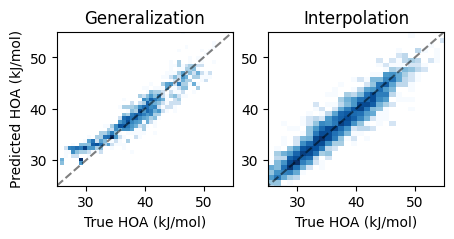

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2))

titles = ['Generalization', 'Interpolation']

for j, i in enumerate([0, 2]):

    th = true_hoas[i]
    ph = pred_hoas[i]

    print(th.min(), th.max(), ph.min(), ph.max())

    ax[j].hist2d(th, ph, bins=(40, 40), norm=LogNorm(), cmap="Blues")

    ax[j].set_xlabel('True HOA (kJ/mol)')
    
    ax[j].set_title(titles[j])

    ax[j].plot([0, 100], [0, 100], 'k--', alpha=0.5)

    ax[j].set_xlim(25, 55)
    ax[j].set_ylim(25, 55)



ax[0].set_ylabel('Predicted HOA (kJ/mol)')

plt.savefig('figures/hoa_parity.pdf')

6.733254126240517e-05 3.4371591209416796 3.976264997618273e-05 3.61428165435791
2.007989156468925e-09 3.547619486588176 2.0915223331030575e-07 3.5392370223999023


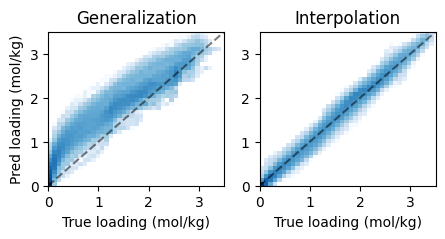

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2))

titles = ['Generalization', 'Interpolation']

for j, i in enumerate([0, 2]):

    th = true_isos[i]
    ph = pred_isos[i]

    th = th.flatten()
    ph = ph.flatten()

    print(th.min(), th.max(), ph.min(), ph.max())

    ax[j].hist2d(th, ph, bins=(40, 40), norm=LogNorm(), cmap="Blues")

    ax[j].set_xlabel('True loading (mol/kg)')
    
    ax[j].set_title(titles[j])

    ax[j].plot([0, 100], [0, 100], 'k--', alpha=0.5)

    ax[j].set_xlim(0, 3.5)
    ax[j].set_ylim(0, 3.5)



ax[0].set_ylabel('Pred loading (mol/kg)')

plt.savefig('figures/iso_parity.pdf')

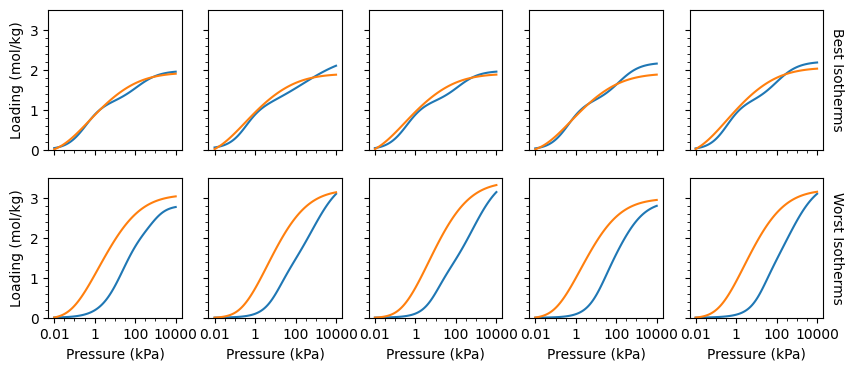

In [32]:
iso_err = np.mean((true_isos[0] - pred_isos[0])**2, axis=-1)


top_5 = np.argsort(iso_err)[:5]
bot_5 = np.argsort(iso_err)[-5:]

fig, ax = plt.subplots(2, 5, figsize=(10, 4))

for i, idx in enumerate(top_5):

    ax[0, i].plot(p.cpu().numpy(), true_isos[0][idx], label='True')
    ax[0, i].plot(p.cpu().numpy(), pred_isos[0][idx], label='Pred')

    # ax[0, i].set_title(f'{iso_err[idx]:.2f}')
    ax[0, i].set_ylim(0, 3.5)

    if i == 0:
        ax[0, i].set_ylabel('Loading (mol/kg)')
        ax[0, i].set_yticks(np.arange(0, 4, 1))
    else:
        ax[0,i].set_yticks(np.arange(0, 4,1), [])

    if i == 4:
        ax[0,i].set_ylabel('Best Isotherms', rotation=270, labelpad=15)
        ax[0,i].yaxis.set_label_position("right")


for i, idx in enumerate(bot_5):

    ax[1,i].plot(p.cpu().numpy(), true_isos[0][idx], label='True')
    ax[1,i].plot(p.cpu().numpy(), pred_isos[0][idx], label='Pred')

    # ax[1,i].set_title(f'{iso_err[idx]:.2f}')
    ax[1,i].set_ylim(0, 3.5)

    if i == 0:
        ax[1, i].set_ylabel('Loading (mol/kg)')
        ax[1, i].set_yticks(np.arange(0, 4, 1))

    else:
        ax[1,i].set_yticks(np.arange(0, 4,1), [])
    
    ax[1, i].set_xlabel('Pressure (kPa)')

    if i == 4:
        ax[1,i].set_ylabel('Worst Isotherms', rotation=270, labelpad=15)
        ax[1,i].yaxis.set_label_position("right")


    ps = np.array([1, 3, 5, 7])
    ax[1,i].set_xticks(ps, [0.01, 1, 100, 10000])
    ax[1,i].set_xticks(np.linspace(1, 7, 13), minor=True)
    ax[0,i].set_xticks(ps, [])
    ax[0,i].set_xticks(np.linspace(1, 7, 13), minor=True)

    ax[0,i].set_yticks(np.arange(0, 3.2, 0.2), minor=True)
    ax[1,i].set_yticks(np.arange(0, 3.2, 0.2), minor=True)

plt.savefig('figures/best_worst_isos.pdf')

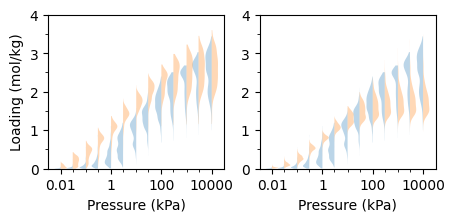

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2))

for i in range(2):

    true_q = true_isos_small[i]
    pred_q = pred_isos_small[i]

    p2_np = p2.squeeze().cpu().numpy()

    viol = ax[i].violinplot(true_q, positions=p2_np, showextrema=False, bw_method='scott', side='low')
    viol = ax[i].violinplot(pred_q, positions=p2_np, showextrema=False, bw_method='scott', side='high')

    ax[i].set_xlim(0.5, 7.5)
    ax[i].set_ylim(0, 4)

    # plot logarithmic major and minor x ticks
    ps = np.array([1, 3, 5, 7])
    ax[i].set_xticks(ps, [0.01, 1, 100, 10000])
    ax[i].set_xticks([1.47712, 2, 2.47712, 3, 3.47712, 4, 4.47712, 5, 5.47712, 6, 6.47712], minor=True)

    ax[i].set_yticks(np.arange(0, 5, 1))
    ax[i].set_yticks(np.arange(0, 4.5, 0.5), minor=True)

    ax[i].set_xlabel('Pressure (kPa)')

ax[0].set_ylabel('Loading (mol/kg)')
    

plt.savefig('figures/iso_violin_true_pred.pdf')

In [34]:
q_idx = [4, 6, 8, 12]
p2_np

array([1.     , 1.47712, 2.     , 2.47712, 3.     , 3.47712, 4.     ,
       4.47712, 5.     , 5.47712, 6.     , 6.47712, 7.     ],
      dtype=float32)

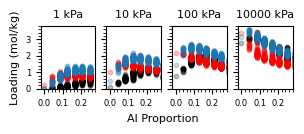

In [35]:
fig, ax = plt.subplots(1,len(q_idx), figsize=(3.25, 3.25/4))




for j in range(len(q_idx)):
    true_q = true_isos_small[0][:, q_idx[j]]
    pred_q_sym = pred_isos_small[0][:, q_idx[j]]
    pred_q_nosym = pred_isos_small[1][:, q_idx[j]]

    al_prop_isos = isos_ats[0]


        
    ax[j].scatter(al_prop_isos, true_q, alpha=0.25, label='True', color='black',s=10)
    ax[j].scatter(al_prop_isos, pred_q_nosym, alpha=0.25, label='Non-symmetric', color='red',s=10)
    ax[j].scatter(al_prop_isos, pred_q_sym, alpha=0.25, label='Symmetric', color='#1F77B4',s=10)
        
    ax[j].set_xlim(-0.02, 0.27)
    ax[j].set_ylim(0, 3.8)

        
    ax[j].set_xticks([0, 0.1, 0.2])
    ax[j].xaxis.set_tick_params(labelsize=tick_size)
    
    if j == 0:
        ax[j].set_yticks([0, 1, 2, 3])
        ax[j].yaxis.set_tick_params(labelsize=tick_size)
        ax[j].set_ylabel('Loading (mol/kg)', fontsize=label_size)
    else:
        ax[j].set_yticks([0, 1, 2, 3], [])
        
        
    ax[j].set_xticks(np.arange(-0.00, 0.3, 0.02), minor=True)
        
    ax[j].set_yticks(np.arange(0.00, 4, 0.2), minor=True)
    
   

# put xlabel in the middle of the plot
fig.text(0.5, -0.3, 'Al Proportion', ha='center', fontsize=label_size)


p_labels = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300, 1000, 3000, 10000]

for j in range(len(q_idx)):

    ax[j].set_title(f'{p_labels[q_idx[j]]} kPa', fontsize=label_size)
    

plt.savefig('figures/iso_scatter_true_pred.pdf', bbox_inches='tight')

# Symmetries

In [36]:
gen_dict = {}

for i, data in enumerate(tr):

    zeo = data.zeo

    if zeo not in gen_dict:
        gen_dict[zeo] = data.gens, data.gen_index

    

In [37]:
gen_list = []

uniq_gen_dict = {}


for zeo in gen_dict:

    uniq_gen_dict[zeo] = []

    gens, idx = gen_dict[zeo]
    max_idx = max(idx)

    for i in range(max_idx+1):

        mask = idx == i

        masked_gens = gens[mask].cpu().numpy()

        if not any(np.array_equal(masked_gens, arr) for arr in gen_list):
            gen_list.append(torch.tensor(masked_gens))

        if not any(np.array_equal(masked_gens, arr) for arr in uniq_gen_dict[zeo]):
            uniq_gen_dict[zeo].append((masked_gens))


In [38]:
plot_zeos = ['MOR', 'ITW', 'DAC', 'STF', 'NAT']

pos_plot = [np.load(f'Data_numpy/{zeo}/pos.npy') for zeo in plot_zeos]
pos_o_plot = [np.load(f'Data_numpy/{zeo}/pos_o.npy') for zeo in plot_zeos]
lens_plot = [np.load(f'Data_numpy/{zeo}/lens.npy') for zeo in plot_zeos]
angs_plot = [np.load(f'Data_numpy/{zeo}/angs.npy') for zeo in plot_zeos]
axes = [(0, 1), (0, 1), (2,0), (0, 1), (0,1)]

In [39]:
gen_list_plot = []

gen_per_atom = []

color_names=  ['blue','red','green','orange','purple','brown','pink','gray','olive','cyan','magenta','yellow','black', 'white']

for zeo in plot_zeos:


    gens, idx = gen_dict[zeo]
    max_idx = max(idx)

    gen_per_atom_zeo = []

    for i in range(max_idx+1):

        mask = idx == i

        masked_gens = gens[mask].cpu().numpy()

        gen_per_atom_zeo.append(torch.tensor(masked_gens))

        if not any(np.array_equal(masked_gens, arr) for arr in gen_list_plot):
            gen_list_plot.append(torch.tensor(masked_gens))


    gen_per_atom.append(gen_per_atom_zeo)


colors = []
for i, gen_zeo in enumerate(gen_per_atom):
    color_zeo = []

    for gen in gen_zeo:

        for j in range(len(gen_list_plot)):
            if torch.equal(gen, gen_list_plot[j]):
                color_zeo.append(color_names[j])

    colors.append(color_zeo)

In [40]:
colors2 = []

color_names=  ['blue', 'cyan', 'turquoise', 'navy', 'red', 'orange', 'brown', 'green', 'olive', 'lime', 'teal', 'purple', 'magenta', 'pink', 'lavender', 'violet', 'black', 'gray']


col_0 = 0

print(len(color_names))
for i, zeo in enumerate(plot_zeos):
    color_zeo = []
    h = get_transform_matrix(*lens_plot[i], *angs_plot[i])
    cell = (h, pos_plot[i], np.zeros(pos_plot[i].shape[0]))

    dataset = spglib.get_symmetry_dataset(cell, symprec=1e-3)

    equi_ats = dataset['equivalent_atoms']

    uniq_equi_ats = np.unique(equi_ats)

    for j in range(len(equi_ats)):
        col_idx = np.where(uniq_equi_ats == equi_ats[j])[0][0] + col_0
        color_zeo.append(color_names[col_idx])

    col_0 += len(uniq_equi_ats)
    
    colors2.append(color_zeo)

    # print(dataset['equivalent_atoms'], len(dataset['equivalent_atoms']), len(pos_plot[i]))

18


In [41]:
widths = [lens_plot[i][x[0]] for i, x in enumerate(axes)]
heights = [lens_plot[i][x[1]] for i, x in enumerate(axes)]

# calculate how to scale each plot, such that all the heights are the same
new_widths = [widths[i] * 1/heights[i] for i in range(len(widths))]

In [42]:
sum(new_widths), widths

(3.91784708725, [18.256, 10.45, 10.377, 14.104, 13.85])

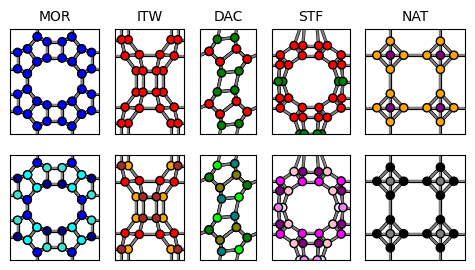

In [43]:

fig, ax = plt.subplots(2, 5, figsize=(sum(new_widths)*1.5, 3), gridspec_kw={'width_ratios': new_widths, 'height_ratios':[1,1]})




for i, zeo in enumerate(plot_zeos):

    (s,t), _ = edge_index_zeo(pos_plot[i], pos_o_plot[i], lens_plot[i], angs_plot[i])
    
    
    pos = pos_plot[i]

    if zeo == 'NAT':
        pos = pos.copy()
        pos[:, 0] += 0.25

        pos = pos % 1

    x, y = axes[i]

    z = 3 - (x + y)
    

    pos = pos

    for j in range(s.size(0)):
        s_j, t_j = s[j].item(), t[j].item()
        x_s, x_t = pos[s_j], pos[t_j]
        diff = x_t - x_s
        diff = diff - diff.round()

        x_t = x_s + diff

        ax[0,i].plot([x_s[x], x_t[x]], [x_s[y], x_t[y]], c='grey', lw=1.5, path_effects=[pe.Stroke(linewidth=2.25, foreground='black'), pe.Normal()])
        ax[1,i].plot([x_s[x], x_t[x]], [x_s[y], x_t[y]], c='grey', lw=1.5, path_effects=[pe.Stroke(linewidth=2.25, foreground='black'), pe.Normal()])
        
        # ax.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=L2,ls='--', )
        

    col = np.array(colors[i])
    col2 = np.array(colors2[i])

    ax[0,i].scatter(pos[:, x], pos[:, y], s=35, c=col, zorder=10, edgecolors='black')
    ax[1,i].scatter(pos[:, x], pos[:, y], s=35, c=col2, zorder=10, edgecolors='black')

    ax[0,i].set_title(zeo, fontsize=title_size)

    ax[0,i].set_xticks([])
    ax[0,i].set_yticks([])
    
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])

    ax[0,i].set_xlim(0, 1)
    ax[0,i].set_ylim(0, 1)

    ax[1,i].set_xlim(0, 1)
    ax[1,i].set_ylim(0, 1)

plt.savefig('figures/gen_zeos.pdf', bbox_inches='tight')

In [44]:
from itertools import chain
import seaborn as sns

In [45]:
gen_len = torch.tensor([len(gen) for gen in gen_list], dtype=torch.long)
gen_idx = torch.arange(len(gen_list), dtype=torch.long).repeat_interleave(gen_len).cuda()

generators = torch.cat(gen_list, dim=0).cuda()

In [46]:
a = [(1,2), (3,4), (5,6)]

(1,2) in a, (1,3) in a

(True, False)

In [47]:
diff_pairs = []
big_diff_pairs = []

diff_pairs_idx = []
big_diff_pairs_idx = []

for i, gen1 in enumerate(gen_list):

    for j, gen2 in enumerate(gen_list):

        if i == j:
            continue

        for z in range(len(gen1)):

            # create a copy of gen1 without the zth element
            gen1_copy = gen1.clone()
            gen1_copy = torch.cat((gen1_copy[:z], gen1_copy[z+1:]), 0)


            # check if gen1_copy is equal to gen2

            if torch.equal(gen1_copy, gen2):
                diff_pairs.append((gen1, gen2))
                diff_pairs_idx.append((i, j))

            else:
                big_diff_pairs.append((gen1, gen2))
                big_diff_pairs_idx.append((i, j))


diff_pairs = list(set(diff_pairs))
big_diff_pairs = list(set(big_diff_pairs))

remove_pairs = []
for i in range(len(big_diff_pairs_idx)):
    
    pair = big_diff_pairs_idx[i]
    
    if pair[::-1] in diff_pairs_idx:
        remove_pairs.append(i)
    if pair in diff_pairs_idx:
        remove_pairs.append(i)

# len(remove_pairs), len(big_diff_pairs), len(diff_pairs)

big_diff_pairs = [pair for i, pair in enumerate(big_diff_pairs) if i not in remove_pairs]

diff1 = [pair[0] for pair in diff_pairs]
diff2 = [pair[1] for pair in diff_pairs]

gen_len1 = torch.tensor([len(gen) for gen in diff1], dtype=torch.long)
gen_idx1 = torch.arange(len(diff1), dtype=torch.long).repeat_interleave(gen_len1).cuda()

generators1 = torch.cat(diff1, dim=0).cuda()

gen_len2 = torch.tensor([len(gen) for gen in diff2], dtype=torch.long)
gen_idx2 = torch.arange(len(diff2), dtype=torch.long).repeat_interleave(gen_len2).cuda()

generators2 = torch.cat(diff2, dim=0).cuda()

diff3 = [pair[0] for pair in big_diff_pairs]
diff4 = [pair[1] for pair in big_diff_pairs]

gen_len3 = torch.tensor([len(gen) for gen in diff3], dtype=torch.long)
gen_idx3 = torch.arange(len(diff3), dtype=torch.long).repeat_interleave(gen_len3).cuda()

generators3 = torch.cat(diff3, dim=0).cuda()

gen_len4 = torch.tensor([len(gen) for gen in diff4], dtype=torch.long)
gen_idx4 = torch.arange(len(diff4), dtype=torch.long).repeat_interleave(gen_len4).cuda()

generators4 = torch.cat(diff4, dim=0).cuda()

In [48]:
pth = f'bestmodel/sym_gen'
with open(f'{pth}/config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

model = GNN(**config['model']).cuda()
model.load_state_dict(torch.load(f'{pth}/final.pth'))

mu, std = np.load(f'{pth}/mu.npy'), np.load(f'{pth}/std.npy')


In [49]:
hypernets = [node.hyper for node in model.node_update_1]

In [50]:
import torch.nn.functional as F

Hypernet 0 gamma sim_small < sim_big: True
Hypernet 0 beta sim_small < sim_big: True
Hypernet 0 small mean: 0.7498674392700195, std: 0.1371900588274002
Hypernet 0 big mean: 0.3440907895565033, std: 0.34099408984184265
Hypernet 1 gamma sim_small < sim_big: True
Hypernet 1 beta sim_small < sim_big: True
Hypernet 1 small mean: 0.6296208500862122, std: 0.24259065091609955
Hypernet 1 big mean: 0.379737913608551, std: 0.3558715283870697
Hypernet 2 gamma sim_small < sim_big: True
Hypernet 2 beta sim_small < sim_big: True
Hypernet 2 small mean: 0.649478554725647, std: 0.24041683971881866
Hypernet 2 big mean: 0.3186012804508209, std: 0.3748486042022705
Hypernet 3 gamma sim_small < sim_big: True
Hypernet 3 beta sim_small < sim_big: True
Hypernet 3 small mean: 0.8155508041381836, std: 0.17992334067821503
Hypernet 3 big mean: 0.42514827847480774, std: 0.35487568378448486
Hypernet 4 gamma sim_small < sim_big: True
Hypernet 4 beta sim_small < sim_big: True
Hypernet 4 small mean: 0.6637230515480042, 

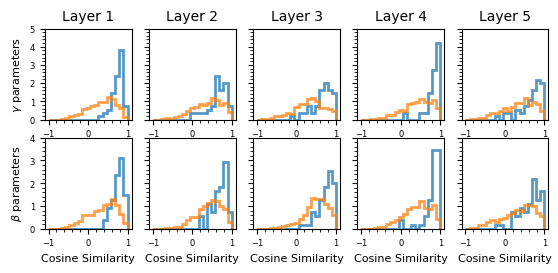

In [51]:
fig, ax = plt.subplots(2, len(hypernets), figsize=(6.5, 2.6))

bins = np.linspace(-1, 1, 20)
for i in range(len(hypernets)):
    
    hyp = hypernets[i]

    with torch.no_grad():
        gamma1, beta1 = hyp.forward(0, generators1, gen_idx1, torch.arange(gen_idx1.max()+1).cuda())
        gamma2, beta2 = hyp.forward(0, generators2, gen_idx2, torch.arange(gen_idx2.max()+1).cuda())
        gamma3, beta3 = hyp.forward(0, generators3, gen_idx3, torch.arange(gen_idx3.max()+1).cuda())
        gamma4, beta4 = hyp.forward(0, generators4, gen_idx4, torch.arange(gen_idx4.max()+1).cuda())

    # D_small = (gamma1 - gamma2).norm(dim=1).cpu().numpy()
    # D_big = (gamma3 - gamma4).norm(dim=1).cpu().numpy()
    # calculate cosine similarity

    g1 = F.normalize(gamma1, p=2, dim=1)
    g2 = F.normalize(gamma2, p=2, dim=1)
    g3 = F.normalize(gamma3, p=2, dim=1)
    g4 = F.normalize(gamma4, p=2, dim=1)

    b1 = F.normalize(beta1, p=2, dim=1)
    b2 = F.normalize(beta2, p=2, dim=1)
    b3 = F.normalize(beta3, p=2, dim=1)
    b4 = F.normalize(beta4, p=2, dim=1)

    D_small = (g1 * g2).sum(dim=1).cpu().numpy()
    D_big = (g3 * g4).sum(dim=1).cpu().numpy()

    D_small_b = (b1 * b2).sum(dim=1).cpu().numpy()
    D_big_b = (b3 * b4).sum(dim=1).cpu().numpy()

    mean_small = np.mean(D_small)
    std_small = np.std(D_small)

    mean_big = np.mean(D_big)
    std_big = np.std(D_big)

    # perform t-test to check if D_small is smaller than D_big
    from scipy.stats import ttest_ind

    t, p = ttest_ind(D_small, D_big, equal_var=False, alternative='greater')
    t_b, p_b = ttest_ind(D_small_b, D_big_b, equal_var=False, alternative='greater')
# 
    # print(f'Hypernet {i} t: {t}, p: {p}')
    
    # print whether D-small < D_big. It is if p < 0.05
    print(f'Hypernet {i} gamma sim_small < sim_big: {p < 0.05}')
    print(f'Hypernet {i} beta sim_small < sim_big: {p_b < 0.05}')
        

    print(f'Hypernet {i} small mean: {mean_small}, std: {std_small}')
    print(f'Hypernet {i} big mean: {mean_big}, std: {std_big}')

    ax[0,i].hist(D_small, bins=bins, histtype='step', alpha=0.75, label=f'Similar', lw=2, density=True)
    ax[0,i].hist(D_big, bins=bins, histtype='step', alpha=0.75, label=f'Different', lw=2, density=True)
    
    ax[1,i].hist(D_small_b, bins=bins, histtype='step', alpha=0.75, label=f'Similar', lw=2, density=True)
    ax[1,i].hist(D_big_b, bins=bins, histtype='step', alpha=0.75, label=f'Different', lw=2, density=True)


    if i == 0:
        ax[0,i].set_ylabel(rf'$\gamma$ parameters', fontsize=label_size)
        ax[1,i].set_ylabel(rf'$\beta$ parameters', fontsize=label_size)
        ax[0,i].set_yticks(np.arange(0, 6, 1))
        ax[1,i].set_yticks(np.arange(0, 5, 1))
        ax[0,i].yaxis.set_tick_params(labelsize=tick_size)
        ax[1,i].yaxis.set_tick_params(labelsize=tick_size)

    else:
        ax[0,i].set_yticks(np.arange(0, 6, 1), [])
        ax[1,i].set_yticks(np.arange(0, 5, 1), [])

    ax[0,i].set_yticks(np.arange(0, 5.2, 0.2), minor=True)    
    
    ax[1,i].set_yticks(np.arange(0, 4.2, 0.2), minor=True)    

    ax[1,i].set_xlabel('Cosine Similarity', fontsize=label_size)
    ax[0,i].set_title(f'Layer {i+1}', fontsize=title_size)

    ax[0,i].set_xticks(np.linspace(-1, 1, 3))
    ax[0,i].set_xticks(np.linspace(-1, 1, 11), minor=True)

    ax[0,i].xaxis.set_tick_params(labelsize=tick_size)
    
    ax[1,i].set_xticks(np.linspace(-1, 1, 3))
    ax[1,i].set_xticks(np.linspace(-1, 1, 11), minor=True)

    
    ax[1,i].xaxis.set_tick_params(labelsize=tick_size)
    
plt.savefig('figures/hypernet_diff.pdf', bbox_inches='tight')

Hypernet 0 gamma sim_small < sim_big: True
Hypernet 0 beta sim_small < sim_big: True
Hypernet 0 small mean: 0.7498674392700195, std: 0.137190043926239
Hypernet 0 big mean: 0.3440907895565033, std: 0.34099408984184265
Hypernet 1 gamma sim_small < sim_big: True
Hypernet 1 beta sim_small < sim_big: True
Hypernet 1 small mean: 0.6296208500862122, std: 0.24259065091609955
Hypernet 1 big mean: 0.379737913608551, std: 0.3558715283870697
Hypernet 2 gamma sim_small < sim_big: True
Hypernet 2 beta sim_small < sim_big: True
Hypernet 2 small mean: 0.649478554725647, std: 0.24041683971881866
Hypernet 2 big mean: 0.3186012804508209, std: 0.3748486340045929
Hypernet 3 gamma sim_small < sim_big: True
Hypernet 3 beta sim_small < sim_big: True
Hypernet 3 small mean: 0.8155508041381836, std: 0.17992334067821503
Hypernet 3 big mean: 0.42514827847480774, std: 0.35487568378448486
Hypernet 4 gamma sim_small < sim_big: True
Hypernet 4 beta sim_small < sim_big: True
Hypernet 4 small mean: 0.6637230515480042, s

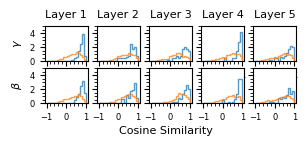

In [52]:
fig, ax = plt.subplots(2, len(hypernets), figsize=(3.25, 1))

bins = np.linspace(-1, 1, 20)
for i in range(len(hypernets)):
    
    hyp = hypernets[i]

    with torch.no_grad():
        gamma1, beta1 = hyp.forward(0, generators1, gen_idx1, torch.arange(gen_idx1.max()+1).cuda())
        gamma2, beta2 = hyp.forward(0, generators2, gen_idx2, torch.arange(gen_idx2.max()+1).cuda())
        gamma3, beta3 = hyp.forward(0, generators3, gen_idx3, torch.arange(gen_idx3.max()+1).cuda())
        gamma4, beta4 = hyp.forward(0, generators4, gen_idx4, torch.arange(gen_idx4.max()+1).cuda())

    
    g1 = F.normalize(gamma1, p=2, dim=1)
    g2 = F.normalize(gamma2, p=2, dim=1)
    g3 = F.normalize(gamma3, p=2, dim=1)
    g4 = F.normalize(gamma4, p=2, dim=1)

    b1 = F.normalize(beta1, p=2, dim=1)
    b2 = F.normalize(beta2, p=2, dim=1)
    b3 = F.normalize(beta3, p=2, dim=1)
    b4 = F.normalize(beta4, p=2, dim=1)

    D_small = (g1 * g2).sum(dim=1).cpu().numpy()
    D_big = (g3 * g4).sum(dim=1).cpu().numpy()

    D_small_b = (b1 * b2).sum(dim=1).cpu().numpy()
    D_big_b = (b3 * b4).sum(dim=1).cpu().numpy()

    mean_small = np.mean(D_small)
    std_small = np.std(D_small)

    mean_big = np.mean(D_big)
    std_big = np.std(D_big)

    # perform t-test to check if D_small is smaller than D_big
    from scipy.stats import ttest_ind

    t, p = ttest_ind(D_small, D_big, equal_var=False, alternative='greater')
    t_b, p_b = ttest_ind(D_small_b, D_big_b, equal_var=False, alternative='greater')


    print(f'Hypernet {i} gamma sim_small < sim_big: {p < 0.05}')
    print(f'Hypernet {i} beta sim_small < sim_big: {p_b < 0.05}')
        

    print(f'Hypernet {i} small mean: {mean_small}, std: {std_small}')
    print(f'Hypernet {i} big mean: {mean_big}, std: {std_big}')

    ax[0,i].hist(D_small, bins=bins, histtype='step', alpha=0.75, label=f'Similar', lw=1, density=True)
    ax[0,i].hist(D_big, bins=bins, histtype='step', alpha=0.75, label=f'Different', lw=1, density=True)
    
    ax[1,i].hist(D_small_b, bins=bins, histtype='step', alpha=0.75, label=f'Similar', lw=1, density=True)
    ax[1,i].hist(D_big_b, bins=bins, histtype='step', alpha=0.75, label=f'Different', lw=1, density=True)


    if i == 0:
        ax[0,i].set_ylabel(rf'$\gamma$', fontsize=label_size)
        ax[1,i].set_ylabel(rf'$\beta$', fontsize=label_size)
        ax[0,i].set_yticks(np.arange(0, 6, 2))
        ax[1,i].set_yticks(np.arange(0, 6, 2))
        ax[0,i].yaxis.set_tick_params(labelsize=tick_size)
        ax[1,i].yaxis.set_tick_params(labelsize=tick_size)

    else:
        ax[0,i].set_yticks(np.arange(0, 6, 2), [])
        ax[1,i].set_yticks(np.arange(0, 6, 2), [])

    ax[0,i].set_yticks(np.arange(0, 5.5, 0.5), minor=True)    
    
    ax[1,i].set_yticks(np.arange(0, 5.5, 0.5), minor=True)    

    # ax[1,i].set_xlabel('Cosine Similarity', fontsize=label_size)
    ax[0,i].set_title(f'Layer {i+1}', fontsize=label_size)

    ax[0,i].set_xticks(np.linspace(-1, 1, 3))
    ax[0,i].set_xticks(np.linspace(-1, 1, 11), minor=True)

    ax[0,i].xaxis.set_tick_params(labelsize=tick_size)
    
    ax[1,i].set_xticks(np.linspace(-1, 1, 3))
    ax[1,i].set_xticks(np.linspace(-1, 1, 11), minor=True)

    
    ax[1,i].xaxis.set_tick_params(labelsize=tick_size)
    
fig.text(0.5, -0.2, 'Cosine Similarity', ha='center', fontsize=label_size)

plt.savefig('figures/hypernet_diff.pdf', bbox_inches='tight')

In [53]:
len(gen_list)

61

In [54]:
gen_list_cha = []
gen_list_itw = []

gens, idx = gen_dict['CHA']
max_idx = max(idx)

for i in range(max_idx+1):

    mask = idx == i

    masked_gens = gens[mask].cpu().numpy()

    if not any(np.array_equal(masked_gens, arr) for arr in gen_list_cha):
        gen_list_cha.append(torch.tensor(masked_gens))


gens, idx = gen_dict['ITW']
max_idx = max(idx)

for i in range(max_idx+1):

    mask = idx == i

    masked_gens = gens[mask].cpu().numpy()

    if not any(np.array_equal(masked_gens, arr) for arr in gen_list_itw):
        gen_list_itw.append(torch.tensor(masked_gens))


In [55]:
gen_list_no_itw = []
gen_list_no_cha = []
gen_list_all = []



for zeo in gen_dict:

    gens, idx = gen_dict[zeo]
    max_idx = max(idx)

    for i in range(max_idx+1):

        mask = idx == i

        masked_gens = gens[mask].cpu().numpy()

        if not any(np.array_equal(masked_gens, arr) for arr in gen_list_all):
            gen_list_all.append(torch.tensor(masked_gens))

            if not any(np.array_equal(masked_gens, arr) for arr in gen_list_cha):
                gen_list_no_cha.append(torch.tensor(masked_gens))
            else:
                print('CHA has the same generator as another zeolite', zeo)
            
            if not any(np.array_equal(masked_gens, arr) for arr in gen_list_itw):
                gen_list_no_itw.append(torch.tensor(masked_gens))
            else:
                print('ITW has the same generator as another zeolite', zeo)


CHA has the same generator as another zeolite CHA
ITW has the same generator as another zeolite COM


In [56]:
len(gen_list_no_cha), len(gen_list_no_itw), len(gen_list_all)

(60, 60, 61)

In [57]:
maes_itw = []
mses_itw = []

maes_itw_iso = []
mses_itw_iso = []

maes_itw_iso_sat = []
mses_itw_iso_sat = []

maes_cha = []
mses_cha = []

p = torch.linspace(1, 7, 100).to('cuda').unsqueeze(-1)
dp = p[1] - p[0]
p_in = torch.cat([p, p[[-1]] + dp], dim=0) - dp/2


for i in tqdm(range(60)):

    special_te = deepcopy(te)

    gen_itw = 24*[gen_list_no_itw[i].numpy()]
    gen_cha = 36*[gen_list_no_cha[i].numpy()]

    gens_itw, gen_index_itw = set_generators(gen_itw)
    gens_cha, gen_index_cha = set_generators(gen_cha)


    for graph in special_te:

        if graph.zeo == 'ITW':
            graph.gens = gens_itw
            graph.gen_index = gen_index_itw

        elif graph.zeo == 'CHA':
            graph.gens = gens_cha
            graph.gen_index = gen_index_cha


    specialloader = DataLoader(special_te, batch_size=64, shuffle=False)

    true_itw = []
    pred_itw = []

    true_iso = []
    pred_iso = []

    true_cha = []
    pred_cha = []

    for data in specialloader:
    
        data = data.to('cuda')
        
        with torch.no_grad():
            out, q_prime_hat = model(data, pres=p_in)
        
        true_isotherm = log_langmuir_freundlich_2s(data.iso_params, p).T
        pred_isotherm = torch.cumulative_trapezoid(q_prime_hat, p_in.squeeze(-1), dim=-1)        

        iso_mask = data.iso == 1
        n_iso = iso_mask.sum().item()

        total_iso += n_iso

        true_isotherm = true_isotherm[iso_mask]
        pred_isotherm = pred_isotherm[iso_mask]

        if n_iso > 0:
            true_iso.extend(true_isotherm.cpu().numpy().tolist())
            pred_iso.extend(pred_isotherm.cpu().numpy().tolist())

        out = out.squeeze(-1)

        true_itw.extend(data.y[iso_mask].cpu().numpy().tolist())
        pred_itw.extend(out[iso_mask].cpu().numpy().tolist())

        true_cha.extend(data.y[~iso_mask].cpu().numpy().tolist())
        pred_cha.extend(out[~iso_mask].cpu().numpy().tolist())

    
    true_itw = np.array(true_itw)
    pred_itw = np.array(pred_itw)
    pred_itw = pred_itw * std + mu

    true_cha = np.array(true_cha)
    pred_cha = np.array(pred_cha)
    pred_cha = pred_cha * std + mu

    true_iso = np.array(true_iso)
    pred_iso = np.array(pred_iso)

    err_itw = np.abs(pred_itw - true_itw)
    mae_itw = np.mean(err_itw)
    mse_itw = np.mean(err_itw**2)

    err_cha = np.abs(pred_cha - true_cha)
    mae_cha = np.mean(err_cha)
    mse_cha = np.mean(err_cha**2)

    err_iso = np.abs(pred_iso - true_iso)
    mae_iso = np.mean(err_iso)
    mse_iso = np.mean(err_iso**2)

    err_iso_sat = np.abs(pred_iso[:,-10:] - true_iso[:,-10:])
    mae_iso_sat = np.mean(err_iso_sat)
    mse_iso_sat = np.mean(err_iso_sat**2)

    maes_itw.append(mae_itw)
    mses_itw.append(mse_itw)

    maes_cha.append(mae_cha)
    mses_cha.append(mse_cha)

    maes_itw_iso.append(mae_iso)
    mses_itw_iso.append(mse_iso)

    maes_itw_iso_sat.append(mae_iso_sat)
    mses_itw_iso_sat.append(mse_iso_sat)
    

100%|██████████| 60/60 [01:38<00:00,  1.64s/it]


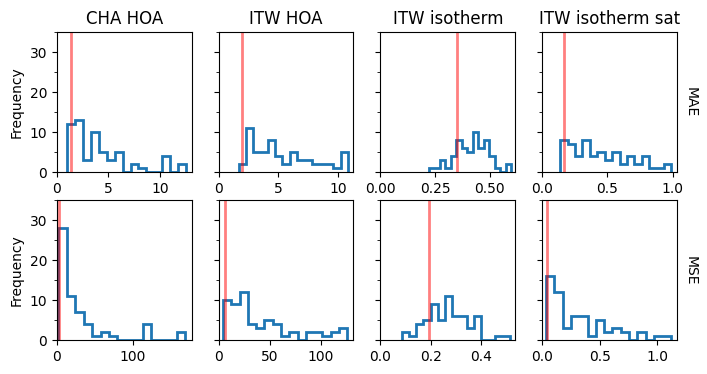

In [58]:
fig, ax = plt.subplots(2, 4, figsize=(8, 4))


bins = 15
line_lim = 50
alpha = 0.5

ax[0,0].hist(maes_cha, bins=bins, histtype='step', lw=2, label='CHA')
ax[0,0].vlines(1.3671, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)
ax[0,0].set_ylabel('Frequency')

ax[0,1].hist(maes_itw, bins=bins, histtype='step', lw=2, label='ITW')
ax[0,1].vlines(1.9723, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)

ax[0,2].hist(maes_itw_iso, bins=bins, histtype='step', lw=2, label='ITW iso')
ax[0,2].vlines(0.3515, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)

ax[0,3].hist(maes_itw_iso_sat, bins=bins, histtype='step', lw=2, label='CHA')
ax[0,3].vlines(0.1667, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)
ax[0,3].set_ylabel('MAE', rotation=270, labelpad=15)
ax[0,3].yaxis.set_label_position("right")

ax[1,0].hist(mses_cha, bins=bins, histtype='step', lw=2, label='CHA')
ax[1,0].vlines(3.244, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)
ax[1,0].set_ylabel('Frequency')
ax[1,1].hist(mses_itw, bins=bins, histtype='step', lw=2, label='ITW')
ax[1,1].vlines(6.5439, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)

ax[1,2].hist(mses_itw_iso, bins=bins, histtype='step', lw=2, label='ITW iso')
ax[1,2].vlines(0.1924, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)

ax[1,3].hist(mses_itw_iso_sat, bins=bins, histtype='step', lw=2, label='CHA')
ax[1,3].vlines(0.04392, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)
ax[1,3].set_ylabel('MSE', rotation=270, labelpad=15)
ax[1,3].yaxis.set_label_position("right")



ax[0,0].set_title('CHA HOA')
ax[0,1].set_title('ITW HOA')
ax[0,2].set_title('ITW isotherm')
ax[0,3].set_title('ITW isotherm sat')


for i in range(4):
    for j in range(2):

        ax[j,i].set_ylim(0, 35)
        ax[j,i].set_xlim(0)

        if i ==0:
            ax[j,i].set_yticks(np.arange(0, 40, 10))
        else:
            ax[j,i].set_yticks(np.arange(0, 40, 10), [])

        ax[j,i].set_yticks(np.arange(0, 40, 5), minor=True)


plt.savefig('figures/mae_mse_diff_sym.pdf')

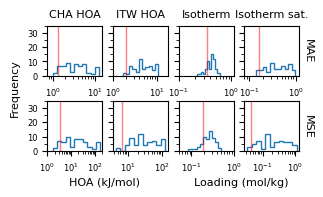

In [59]:
# add additional space between rows
fig, ax = plt.subplots(2, 4, figsize=(3.25, 1.625), gridspec_kw={'hspace': 0.5})


n_bins = 12

line_lim = 50
alpha = 0.5


maes_cha = np.array(maes_cha)
mses_cha = np.array(mses_cha)

maes_itw = np.array(maes_itw)
mses_itw = np.array(mses_itw)

maes_itw_iso = np.array(maes_itw_iso)
mses_itw_iso = np.array(mses_itw_iso)

maes_itw_iso_sat = np.array(maes_itw_iso_sat)
mses_itw_iso_sat = np.array(mses_itw_iso_sat)


bins = np.geomspace(maes_cha.min(), maes_cha.max(), n_bins)
ax[0,0].hist(maes_cha, bins=bins, histtype='step', lw=1, label='CHA')
ax[0,0].vlines(1.3671, 0, line_lim, color='r', lw=1, label='Baseline', alpha=alpha)
# ax[0,0].set_ylabel('Frequency', fontsize=label_size)
ax[0,0].set_xscale('log')
ax[0,0].set_xlim(0.75, 15)

bins = np.geomspace(maes_itw.min(), maes_itw.max(), n_bins)
ax[0,1].hist(maes_itw, bins=bins, histtype='step', lw=1, label='ITW')
ax[0,1].vlines(1.9723, 0, line_lim, color='r', lw=1, label='Baseline', alpha=alpha)
ax[0,1].set_xscale('log')
ax[0,1].set_xlim(1, 18)


bins = np.geomspace(maes_itw_iso.min(), maes_itw_iso.max(), n_bins)
ax[0,2].hist(maes_itw_iso, bins=bins, histtype='step', lw=1, label='ITW iso')
ax[0,2].vlines(0.3515, 0, line_lim, color='r', lw=1, label='Baseline', alpha=alpha)
ax[0,2].set_xscale('log')
ax[0,2].set_xlim(0.1, 1.1)

bins = np.geomspace(maes_itw_iso_sat.min(), maes_itw_iso_sat.max(), n_bins)
ax[0,3].hist(maes_itw_iso_sat, bins=bins, histtype='step', lw=1, label='CHA')
ax[0,3].vlines(0.1667, 0, line_lim, color='r', lw=1, label='Baseline', alpha=alpha)
ax[0,3].set_ylabel('MAE', rotation=270, labelpad=10, fontsize=label_size)
ax[0,3].yaxis.set_label_position("right")
ax[0,3].set_xscale('log')
ax[0,3].set_xlim(0.08, 1.2)

bins = np.geomspace(mses_cha.min(), mses_cha.max(), n_bins)
ax[1,0].hist(mses_cha, bins=bins, histtype='step', lw=1, label='CHA')
ax[1,0].vlines(3.244, 0, line_lim, color='r', lw=1, label='Baseline', alpha=alpha)
# ax[1,0].set_ylabel('Frequency', fontsize=label_size)
ax[1,0].set_xscale('log')
ax[1,0].set_xlim(1,200)

bins = np.geomspace(mses_itw.min(), mses_itw.max(), n_bins)
ax[1,1].hist(mses_itw, bins=bins, histtype='step', lw=1, label='ITW')
ax[1,1].vlines(6.5439, 0, line_lim, color='r', lw=1, label='Baseline', alpha=alpha)
ax[1,1].set_xscale('log')

bins = np.geomspace(mses_itw_iso.min(), mses_itw_iso.max(), n_bins)
ax[1,2].hist(mses_itw_iso, bins=bins, histtype='step', lw=1, label='ITW iso')
ax[1,2].vlines(0.1924, 0, line_lim, color='r', lw=1, label='Baseline', alpha=alpha)
ax[1,2].set_xscale('log')
ax[1,2].set_xlim(0.05, 1)

bins = np.geomspace(mses_itw_iso_sat.min(), mses_itw_iso_sat.max(), n_bins)
ax[1,3].hist(mses_itw_iso_sat, bins=bins, histtype='step', lw=1, label='CHA')
ax[1,3].vlines(0.04392, 0, line_lim, color='r', lw=1, label='Baseline', alpha=alpha)
ax[1,3].set_ylabel('MSE', rotation=270, labelpad=10, fontsize=label_size)
ax[1,3].yaxis.set_label_position("right")
ax[1,3].set_xscale('log')


ax[0,0].set_title('CHA HOA', fontsize=label_size)
ax[0,1].set_title('ITW HOA', fontsize=label_size)
ax[0,2].set_title('Isotherm', fontsize=label_size)
ax[0,3].set_title('Isotherm sat.', fontsize=label_size)


for i in range(4):
    for j in range(2):

        ax[j,i].set_ylim(0, 35)
        # ax[j,i].set_xlim(0)

        if i ==0:
            ax[j,i].set_yticks(np.arange(0, 40, 10))
            ax[j,i].yaxis.set_tick_params(labelsize=tick_size)
        else:
            ax[j,i].set_yticks(np.arange(0, 40, 10), [])

        ax[j,i].set_yticks(np.arange(0, 40, 5), minor=True)

        ax[j,i].xaxis.set_tick_params(labelsize=tick_size)


# put frequency label on the left side in the middle
fig.text(0.01, 0.5, 'Frequency', va='center', rotation='vertical', fontsize=label_size)
fig.text(0.3, -0.1, 'HOA (kJ/mol)', ha='center', fontsize=label_size)
fig.text(0.72, -0.1, 'Loading (mol/kg)', ha='center', fontsize=label_size)

# plt.tight_layout()
plt.savefig('figures/mae_mse_diff_sym.pdf', bbox_inches='tight')

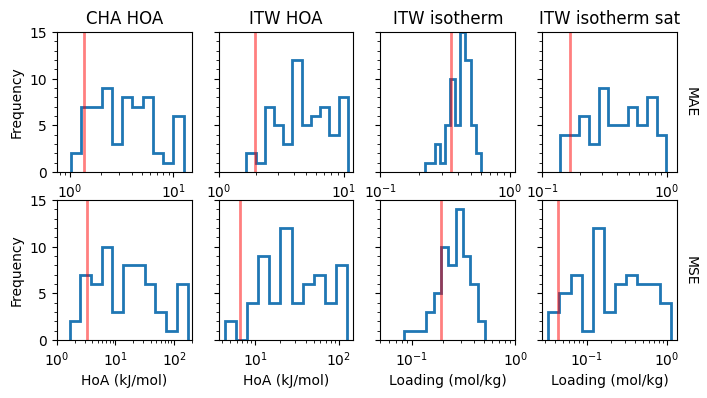

In [60]:
fig, ax = plt.subplots(2, 4, figsize=(8, 4))


n_bins = 12
line_lim = 50
alpha = 0.5


maes_cha = np.array(maes_cha)
mses_cha = np.array(mses_cha)

maes_itw = np.array(maes_itw)
mses_itw = np.array(mses_itw)

maes_itw_iso = np.array(maes_itw_iso)
mses_itw_iso = np.array(mses_itw_iso)

maes_itw_iso_sat = np.array(maes_itw_iso_sat)
mses_itw_iso_sat = np.array(mses_itw_iso_sat)


bins = np.geomspace(maes_cha.min(), maes_cha.max(), n_bins)
ax[0,0].hist(maes_cha, bins=bins, histtype='step', lw=2, label='CHA')
ax[0,0].vlines(1.3671, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_xscale('log')
ax[0,0].set_xlim(0.75, 15)

bins = np.geomspace(maes_itw.min(), maes_itw.max(), n_bins)
ax[0,1].hist(maes_itw, bins=bins, histtype='step', lw=2, label='ITW')
ax[0,1].vlines(1.9723, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)
ax[0,1].set_xscale('log')
ax[0,1].set_xlim(1, 12)

bins = np.geomspace(maes_itw_iso.min(), maes_itw_iso.max(), n_bins)
ax[0,2].hist(maes_itw_iso, bins=bins, histtype='step', lw=2, label='ITW iso')
ax[0,2].vlines(0.3515, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)
ax[0,2].set_xscale('log')
ax[0,2].set_xlim(0.1, 1.1)

bins = np.geomspace(maes_itw_iso_sat.min(), maes_itw_iso_sat.max(), n_bins)
ax[0,3].hist(maes_itw_iso_sat, bins=bins, histtype='step', lw=2, label='CHA')
ax[0,3].vlines(0.1667, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)
ax[0,3].set_ylabel('MAE', rotation=270, labelpad=15)
ax[0,3].yaxis.set_label_position("right")
ax[0,3].set_xscale('log')
ax[0,3].set_xlim(0.1, 1.2)

bins = np.geomspace(mses_cha.min(), mses_cha.max(), n_bins)
ax[1,0].hist(mses_cha, bins=bins, histtype='step', lw=2, label='CHA')
ax[1,0].vlines(3.244, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)
ax[1,0].set_ylabel('Frequency')
ax[1,0].set_xscale('log')
ax[1,0].set_xlim(1,200)

bins = np.geomspace(mses_itw.min(), mses_itw.max(), n_bins)
ax[1,1].hist(mses_itw, bins=bins, histtype='step', lw=2, label='ITW')
ax[1,1].vlines(6.5439, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)
ax[1,1].set_xscale('log')

bins = np.geomspace(mses_itw_iso.min(), mses_itw_iso.max(), n_bins)
ax[1,2].hist(mses_itw_iso, bins=bins, histtype='step', lw=2, label='ITW iso')
ax[1,2].vlines(0.1924, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)
ax[1,2].set_xscale('log')
ax[1,2].set_xlim(0.05, 1)

bins = np.geomspace(mses_itw_iso_sat.min(), mses_itw_iso_sat.max(), n_bins)
ax[1,3].hist(mses_itw_iso_sat, bins=bins, histtype='step', lw=2, label='CHA')
ax[1,3].vlines(0.04392, 0, line_lim, color='r', lw=2, label='Baseline', alpha=alpha)
ax[1,3].set_ylabel('MSE', rotation=270, labelpad=15)
ax[1,3].yaxis.set_label_position("right")
ax[1,3].set_xscale('log')

ax[0,0].set_title('CHA HOA')
ax[0,1].set_title('ITW HOA')
ax[0,2].set_title('ITW isotherm')
ax[0,3].set_title('ITW isotherm sat')

ax[1,0].set_xlabel('HoA (kJ/mol)')
ax[1,1].set_xlabel('HoA (kJ/mol)')
ax[1,2].set_xlabel('Loading (mol/kg)')
ax[1,3].set_xlabel('Loading (mol/kg)')


for i in range(4):
    for j in range(2):

        ax[j,i].set_ylim(0, 15)
        # ax[j,i].set_xlim(0)

        if i ==0:
            ax[j,i].set_yticks(np.arange(0, 20, 5))
        else:
            ax[j,i].set_yticks(np.arange(0, 20, 5), [])

        ax[j,i].set_yticks(np.arange(0, 16, 1), minor=True)

        ax[j, i].xaxis.set_major_locator(LogLocator(base=10.0, numticks=2))

plt.savefig('figures/mae_mse_diff_sym.pdf', bbox_inches='tight')

# Genetic Algorithm

In [61]:
best_mfi_95 = np.load('ga_results/best_mfi_95.npy')
best_mfi_31 = np.load('ga_results/best_mfi_31.npy')
best_mor_5p8 = np.load('ga_results/best_mor_5p8.npy')
best_mor_6p5 = np.load('ga_results/best_mor_6p5.npy')
best_lta_1 = np.load('ga_results/best_lta_1.npy')

bests = [best_mfi_95, best_mfi_31, best_mor_5p8, best_mor_6p5, best_lta_1]
best_names = ['MFI Si/Al: 95', 'MFI Si/Al: 31', 'MOR Si/Al: 5.8', 'MOR Si/Al: 6.5', 'LTA Si/Al: 1']
num_als = [1, 3, 7, 6.4, 12]

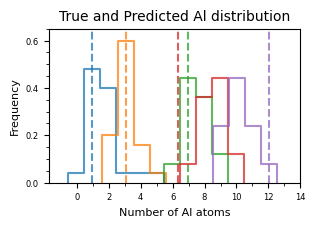

In [62]:
plt.figure(figsize=(3.25, 2));

for i in range(len(bests)):
    best_al = bests[i].sum(-1)
    n_al, cnts = np.unique(best_al, return_counts=True)

    cnts = cnts/len(best_al)

    extended_n_al = np.concatenate([[n_al[0] - 1], n_al, [n_al[-1] + 1]])

    mod_al = 0
    if i == 0 or i == 2 or i == 3:
        extended_n_al -= 0.06
        mod_al = -0.06
    elif i == 1 or i == 4:
        extended_n_al += 0.06
        mod_al = 0.06

    
    extended_cnts = np.concatenate([[-1], cnts, [-1]])  # Ensure it drops to zero at edges



    step = plt.step(extended_n_al, extended_cnts, where='mid', linewidth=1.5, alpha=0.75)

    plt.vlines(num_als[i] + mod_al, 0, 1, color=step[0].get_color(), linestyle='--', alpha=0.75)


plt.xlabel('Number of Al atoms', fontsize=label_size)
plt.ylabel('Frequency', fontsize=label_size)

plt.yticks(np.arange(0, 1.1, 0.2), fontsize=tick_size)
plt.yticks(np.arange(0, 1.25, 0.05), minor=True)

plt.xticks(np.arange(0, 15, 2), fontsize=tick_size)
plt.xticks(np.arange(0, 15, 1), minor=True)

plt.ylim(0, 0.65)

plt.title('True and Predicted Al distribution', fontsize=title_size)
plt.savefig('figures/al_distribution.pdf', bbox_inches='tight')